In [ ]:
# Commands to download the COCO dataset
# wget http://images.cocodataset.org/zips/train2017.zip
# wget http://images.cocodataset.org/zips/val2017.zip
# wget http://images.cocodataset.org/zips/test2017.zip
# wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

## Libraries

In [1]:
import importlib
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seedir
import yaml
from matplotlib import colormaps
from torch.utils.data import DataLoader

sys.path.insert(0, '../src')
import dataset

importlib.reload(dataset)
from dataset import COCOSegmentationDataset

## Data exploration

In [2]:
external_disk_path = "/media/tiagociiic/easystore"
dataset_dir = os.path.join(external_disk_path, "COCO_dataset")
val_dir = os.path.join(dataset_dir, "val2017")
seedir.seedir(val_dir, itemlimit=3, style='lines', indent=4)

val2017/
├───000000000139.jpg
├───000000000285.jpg
└───000000000632.jpg


## COCOSegmentationDataset class testing

In [9]:
def show_image_and_mask(image, mask, denormalize=True, mean=None, std=None):
    """
    Displays an image and its corresponding mask, with the option to denormalize 
    the image and display the mask with different colors for each class.

    Args:
        image (tensor): The input image tensor.
        mask (tensor): The input mask tensor.
        denormalize (bool, optional): Whether to denormalize the image. Defaults to True.
        mean (list or array, optional): The mean values for denormalization. Defaults to None.
        std (list or array, optional): The standard deviation values for denormalization. Defaults to None.

    Returns:
        None
    """
    # Convert tensors to numpy arrays
    image = image.permute(1, 2, 0).cpu().numpy()
    mask = mask.cpu().numpy()

    # Denormalize the image
    if denormalize:
        if mean is None or std is None:
            raise ValueError("Mean and std must be provided for denormalization")
        image = image * np.array(std) + np.array(mean)

    # Clip the pixel values to [0, 1]
    image = np.clip(image, 0, 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Plots the image
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')

    # Prepare the mask for plotting
    num_classes = mask.shape[0]
    mask_rgb = np.zeros((*mask.shape[1:], 3), dtype=np.float32)

    # Create a color map
    cmap = colormaps['tab20']
    colors = cmap(np.linspace(0, 1, num_classes))

    # Color the mask
    for i in range(num_classes):
        mask_rgb[mask[i] == 1] = colors[i, :3]

    # Plot the mask
    ax2.imshow(mask_rgb)
    ax2.set_title('Mask (Multi-class)')
    ax2.axis('off')

    # Add a legend
    classes = [f'Class {i + 1}' for i in range(num_classes)]
    patches = [plt.Rectangle((0, 0), 1, 1, fc=colors[i, :3]) for i in range(num_classes)]
    plt.legend(patches, classes, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

    print(f"Image shape: {image.shape}, max: {image.max():.2f}, min: {image.min():.2f}")
    print(f"Mask shape: {mask.shape}, num classes: {num_classes}, max: {mask.max():.2f}, min: {mask.min():.2f}")

In [4]:
with open('../environment.yml', 'r') as f:
    config = yaml.safe_load(f)

coco_img_mean = config['vars']['COCO_IMG_MEAN']
coco_img_std = config['vars']['COCO_IMG_STD']

year = '2017'
image_size = (512, 512)
classes_ids = [1, 72, 73, 77]

# 0: background
# 1: person
# 72: tv
# 73: laptop
# 77: cell phone

In [5]:
coco_dataset = COCOSegmentationDataset(root_dir=dataset_dir,
                                       split='train',
                                       year=year,
                                       image_size=image_size,
                                       selected_class_ids=classes_ids, mask_size=(256, 256))

TypeError: COCOSegmentationDataset.__init__() missing 1 required positional argument: 'mask_size'

In [7]:
train_dataset = dataset.COCOSegmentationDataset(root_dir=dataset_dir,
                                                split='train',
                                                year=year,
                                                image_size=image_size,
                                                selected_class_ids=classes_ids, mask_size=(256, 256))

loading annotations into memory...
Done (t=7.84s)
creating index...
index created!


masks shape: torch.Size([2, 4, 256, 256])


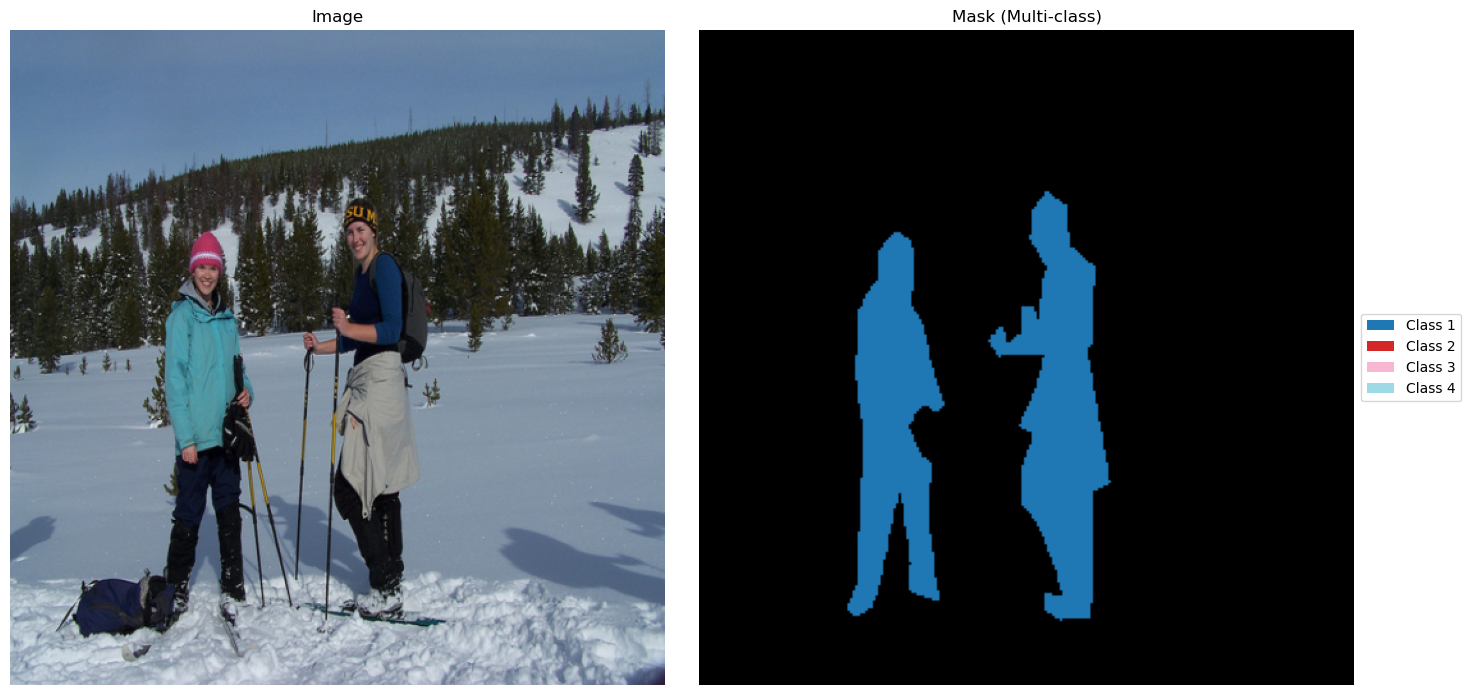

Image shape: (512, 512, 3), max: 0.94, min: 0.00
Mask shape: (4, 256, 256), num classes: 4, max: 1.00, min: 0.00


In [10]:

dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

batch = next(iter(dataloader))
images = batch['image']
masks = batch['mask']
print(f"masks shape: {masks.shape}")

show_image_and_mask(images[0], masks[0], denormalize=True, mean=coco_img_mean, std=coco_img_std)

In [125]:
with open('../environment.yml', 'r') as f:
    config = yaml.safe_load(f)

coco_img_mean = config['vars']['COCO_IMG_MEAN']
coco_img_std = config['vars']['COCO_IMG_STD']
print(f"Image mean: {coco_img_mean}, std: {coco_img_std}")

Image mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]
